In [1]:
import datetime as dt
import utils
from sentinelsat import SentinelAPI
import json
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rasterio import plot

In [2]:
geojson_path = "data/var.geojson"
dates = (dt.date(2021, 8, 2), dt.date(2021, 8, 16))
credentials_path = "secrets/sentinel_api_credentials.json"

In [3]:
with open(credentials_path, 'r') as infile:
    credentials = json.load(infile)

api = SentinelAPI(
    credentials["username"],
    credentials["password"]
)

In [ ]:
images_df = utils.get_dataframe_between_dates(api, dates[0], dates[1], geojson_path)

In [ ]:
images_df = utils.minimize_dataframe(images_df)

In [ ]:
key_cols = ["cloudcoverpercentage", "vegetationpercentage",
            "waterpercentage", "size", "ingestiondate", "score"]
images_df[key_cols]

In [ ]:
images_df.dtypes

In [ ]:
uuid, title = utils.get_uuid_title(images_df)

In [ ]:
path = './data/'
utils.download_from_api(api, uuid, title, path)

In [ ]:
corr_matrix = images_df.corr()

plt.figure(figsize=(10, 10))
hm = sns.heatmap(corr_matrix, linewidths=1, linecolor='gray', cmap='coolwarm')
hm.set_yticklabels(hm.get_yticklabels(), fontsize=11)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45, fontsize=11, ha='right')
plt.show()

In [5]:
wildfire_date = dt.date(2021, 8, 17)
observation_interval = 15

In [6]:
test1 = utils.get_image(api=api, wildfire_date=wildfire_date,
    observation_interval=observation_interval, when='before',
    geojson_path=geojson_path, path='data/',
    band1='B04', band2='B08', output_folder='output/', resolution=10)

Retrieved dataframe.

Number of images between 2021-08-02 and 2021-08-16: 11
Minimizing dataframe...

Dropping images with low vegetation.

Retrieved best uuid and title from the dataframe on row 3.

cloudcoverpercentage                       6.51441
vegetationpercentage                     71.114808
waterpercentage                           2.582955
score                                    21.834042
ingestiondate           2021-08-02 19:28:01.327000
size                                       1146.88
Name: 85fd3f39-2c71-4867-bc0c-cb383cf302af, dtype: object
First image selected for NDVI: T31TGJ_20210802T102559_B04_10m.jp2
Second image selected for NDVI: T31TGJ_20210802T102559_B08_10m.jp2


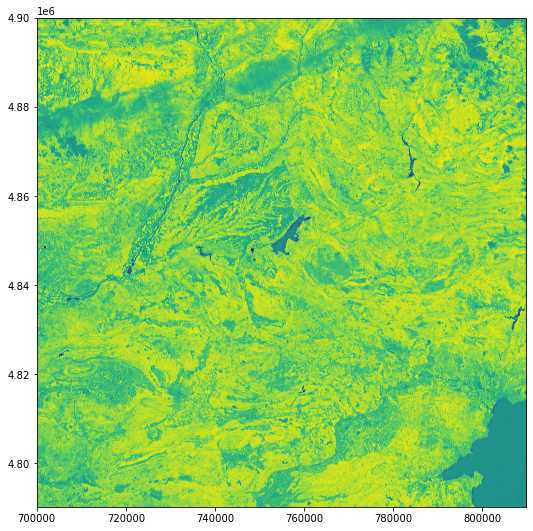

In [7]:
plt.figure(figsize=(16, 9))
plot.show(test1)
plt.show()

In [ ]:
wildfire_date = dt.date(2021, 8, 17)
observation_interval = 15

In [6]:
test2 = utils.get_image(api=api, wildfire_date=wildfire_date,
    observation_interval=observation_interval, when='after',
    geojson_path=geojson_path, path='data/',
    band1='B04', band2='B08', output_folder='output/', resolution=10)

Retrieved dataframe.

Number of images between 2021-08-17 and 2021-09-01: 19
Minimizing dataframe...

Dropping images with low vegetation.

Retrieved best uuid and title from the dataframe on row 1.

cloudcoverpercentage                      1.718797
vegetationpercentage                     72.823709
waterpercentage                           2.596592
score                                    12.422648
ingestiondate           2021-08-17 16:51:32.284000
size                                       1157.12
Name: cfb0c9b0-c030-41ba-89ac-d48f0634dc5e, dtype: object
First image selected for NDVI: T31TGJ_20210817T103021_B04_10m.jp2
Second image selected for NDVI: T31TGJ_20210817T103021_B08_10m.jp2


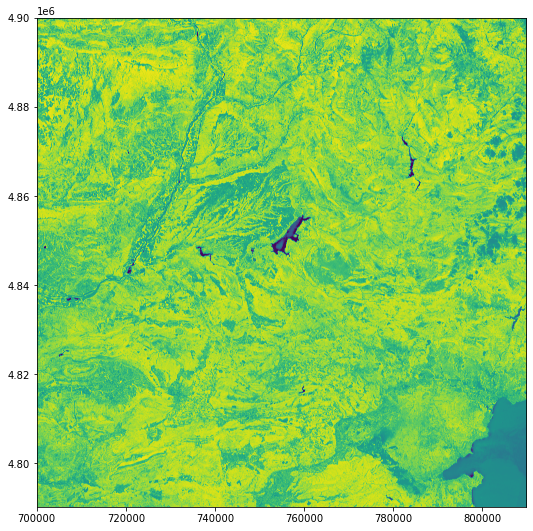

In [7]:
plt.figure(figsize=(16, 9))
plot.show(test2)
plt.show()

In [10]:
test1 = test1.read(1)
test2 = test2.read(1)

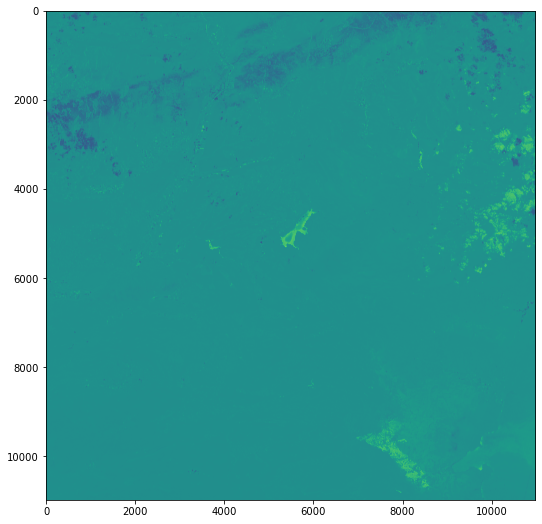

In [15]:
diff = test1 - test2

plt.figure(figsize=(16, 9))
plt.imshow(diff)
plt.show()

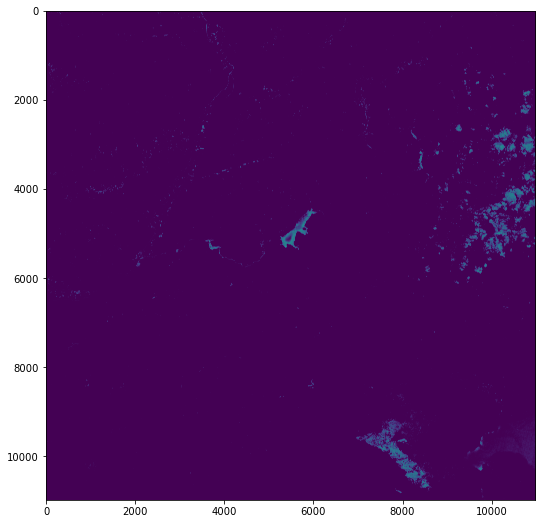

In [16]:
diff = utils.threshold_filter(diff, 0.25)

plt.figure(figsize=(16, 9))
plt.imshow(diff)
plt.show()

In [ ]:
before_image, after_image = utils.get_before_after_images(
    api, dt.date(2021, 8, 17), 14, geojson_path,
    "B04", "B08", cloud_threshold=40, resolution=10
)

In [ ]:
plt.imshow(before_image)
plt.show()